In [1]:
# 加载数据分析常用库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
% matplotlib inline

In [2]:
#TRAINING_METAPATH = "D:/dataset/paddle/store/training.json"
VALIDATION_METAPATH = "D:/dataset/paddle/store/validation.json"
TESTING_METAPATH = "D:/dataset/paddle/store/testing.json"

#train_info = pd.read_json(TRAINING_METAPATH)
valid_info = pd.read_json(VALIDATION_METAPATH)
test_info = pd.read_json(TESTING_METAPATH)

In [3]:
print (valid_info.shape,test_info.shape)

((115, 2), (114, 2))


In [4]:
#train_database = train_info["database"]
valid_database = valid_info["database"]
test_database = test_info["database"]

In [5]:
DATA_DIR = "D:/dataset/paddle/valid/"
def generater_dataset(file_name):
    file_name_path = os.path.join(DATA_DIR,str(file_name)+".pkl")
    X = np.load(file_name_path)
    X = np.array(X)
    
    ## get Y label
    valid_new_list = []
    for valid_list in valid_database[file_name]["annotations"]:
        valid_new_list = valid_new_list + valid_list['segment']
    # 转换为 整数
    valid_new_list = np.array(valid_new_list,dtype="int")
    
    label = np.zeros((X.shape[0],1),dtype=np.int8)
    for i in range(len(valid_new_list)/2):
        label[valid_new_list[2*i]:valid_new_list[2*i+1]] =1
    return X,label

In [6]:
a = valid_database.keys()
x_train,y_train = generater_dataset(a[0])
x_test,y_test = generater_dataset(a[100])
print x_train.shape

(4861L, 2048L)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [8]:
y_train = y_train.ravel()
y_test =  y_test.ravel()
# 归一化
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

# 逻辑回归
model = LogisticRegression()
model.fit(x_train, y_train)

# 预测
predict = model.predict(x_test)
right = sum(predict == y_test)

predict = np.hstack((predict.reshape(-1, 1), y_test.reshape(-1, 1)))  # 将预测值和真实值放在一块，好观察
print(predict)
print('测试集准确率：%s%%' % (right * 100.0 / predict.shape[0]))  # 计算在测试集上的准确度

[[0 0]
 [0 0]
 [1 0]
 ..., 
 [0 0]
 [0 0]
 [0 0]]
测试集准确率：39.4663480685%


## 效果不是很准，感觉需要修正这里啊。预测没法看了

In [ ]:
predict[:,0].shape,y_test.shape

In [13]:
predict_origin = model.predict(x_test)

In [15]:
print predict_origin[0]

0


3080

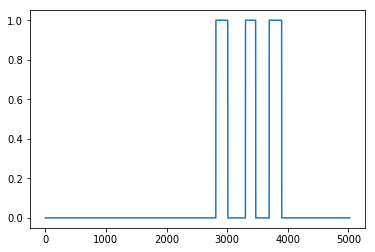

In [12]:
predict_data = predict[:,0]
plt.plot(y_test)
y_test.sum()
predict_data.sum()

# 看到这里我们的预测基本为0.没有好预测。。。
提高这里的预测是这里需要解决的地方

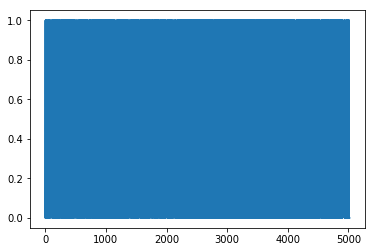

In [37]:
plt.plot(predict_data)

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
% matplotlib inline

In [ ]:
DATA_DIR_TEST = "D:/dataset/paddle/test/"
def generater_dataset_test(file_name):
    file_name_path = os.path.join(DATA_DIR_TEST,str(file_name)+".pkl")
    X = np.load(file_name_path)
    X = np.array(X)
    return X

In [ ]:
def generater_score():
    new_list = []
    threshold = 0.0
    
    proposal_data = {'results': {}, 'version': "VERSION 1.0"}
    
    for test_video_name in test_database.keys():
        pre_seg = []
        this_vid_proposals = []
        pre_i = 0
        max_duration=300
        min_duration=30
        avg_nr_proposals = 10
        
        #print (test_video_name)
        x_test = generater_dataset_test(test_video_name)
        predict = model.predict(x_test)
        for i in range(len(predict)):
            if predict[i]==1 or threshold > 0.4:
                new_list.append(predict[i])      
                threshold = new_list.count(1)*1.0/len(new_list)

                if len(new_list)> 30:
                    if i-pre_i>1 and len(pre_seg)!=0:

                        proposal = {
                            'score': threshold,
                            'segment': pre_seg,
                           }
                        this_vid_proposals += [proposal]

                    pre_i = i
                    pre_seg  = [pre_i-len(new_list),pre_i]
            else:
                new_list = []
                threshold = 0.0
        # 添加部分随机数据代替
        if len(this_vid_proposals)  < 10:
            video_duration = x_test.shape[0]
            for _ in range(avg_nr_proposals):
                # generate random proposal center, length, and score
                center = video_duration*np.random.rand(1)[0]
                length = (max_duration-min_duration)*np.random.rand(1)[0]+min_duration
                proposal = {
                            'score': np.random.rand(1)[0],
                            'segment': [center - length/2., center + length/2.],
                           }
                this_vid_proposals += [proposal]
            
        proposal_data['results'][test_video_name] = this_vid_proposals
    return proposal_data
proposal_data =generater_score() 

In [ ]:
import json
subset = "one_testing"
with open("D:/dataset/paddle/submit/uniform_random_proposals_"+subset+".json", 'w') as fobj:
    json.dump(proposal_data, fobj)